In [72]:
from langgraph.graph import StateGraph , START, END
from typing import TypedDict, Annotated
from pydantic import BaseModel, Field
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint
from dotenv import load_dotenv
import operator
load_dotenv()

True

In [57]:
llm = HuggingFaceEndpoint(
    repo_id="openai/gpt-oss-20b",
    task="text-generation"
)

model = ChatHuggingFace(llm=llm)


In [73]:
llm2 = HuggingFaceEndpoint(
    repo_id="google/gemma-2-2b-it",
    task="text-generation"
)

model2 = ChatHuggingFace(llm=llm2)

In [58]:
class EvaluationSchema(BaseModel):

    feedback: str = Field(description='Detailed feedbackfor the essay')
    score: int = Field(description='Score out of 10', ge=0, le=10)
    

In [59]:
structured_model = model.with_structured_output(EvaluationSchema,method="json_schema" )

In [60]:
essay = """India in the Age of AI
As the world enters a transformative era defined by artificial intelligence (AI), India stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how India navigates this landscape will shape its socio-economic and geopolitical future.

India's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, India possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for All) with a focus on inclusive growth, aiming to leverage AI in healthcare, agriculture, education, and smart mobility.

One of the most promising applications of AI in India lies in agriculture, where predictive analytics can guide farmers on optimal sowing times, weather forecasts, and pest control. In healthcare, AI-powered diagnostics can help address India’s doctor-patient ratio crisis, particularly in rural areas. Educational platforms are increasingly using AI to personalize learning paths, while smart governance tools are helping improve public service delivery and fraud detection.

However, the path to AI-led growth is riddled with challenges. Chief among them is the digital divide. While metropolitan cities may embrace AI-driven solutions, rural India continues to struggle with basic internet access and digital literacy. The risk of job displacement due to automation also looms large, especially for low-skilled workers. Without effective skilling and re-skilling programs, AI could exacerbate existing socio-economic inequalities.

Another pressing concern is data privacy and ethics. As AI systems rely heavily on vast datasets, ensuring that personal data is used transparently and responsibly becomes vital. India is still shaping its data protection laws, and in the absence of a strong regulatory framework, AI systems may risk misuse or bias.

To harness AI responsibly, India must adopt a multi-stakeholder approach involving the government, academia, industry, and civil society. Policies should promote open datasets, encourage responsible innovation, and ensure ethical AI practices. There is also a need for international collaboration, particularly with countries leading in AI research, to gain strategic advantage and ensure interoperability in global systems.

India’s demographic dividend, when paired with responsible AI adoption, can unlock massive economic growth, improve governance, and uplift marginalized communities. But this vision will only materialize if AI is seen not merely as a tool for automation, but as an enabler of human-centered development.

In conclusion, India in the age of AI is a story in the making — one of opportunity, responsibility, and transformation. The decisions we make today will not just determine India’s AI trajectory, but also its future as an inclusive, equitable, and innovation-driven society."""

In [61]:
prompt = (
    "Evaluate the language quality of the following essay and provide feedback "
    "and assign a score out of 10. Respond ONLY in valid JSON.\n\n"
    f"{essay}"
)
response=structured_model.invoke(prompt)

In [71]:
print(response["feedback"])
print("Score:", response["score"])

The essay demonstrates clear, coherent prose with strong organization and a balanced discussion of opportunities and challenges. Vocabulary is appropriate and varied, and technical terms are correctly employed. Sentence structures are mostly complex but readable, and transitions flow smoothly. Minor improvements could include tightening some repetitive phrases, refining a few grammatical nuances, and adding more concrete data points or examples to support claims. Overall, the language quality is high and effectively conveys the topic.
Score: 9


In [74]:
class UPSCState(TypedDict):

    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float

In [84]:
def lang_feedback(state: UPSCState):
    prompt = (
        "Evaluate the language quality of the following essay and provide feedback "
        "and assign a score out of 10. Respond ONLY in valid JSON.\n\n"
        f"{state['essay']}"
    )
    response=structured_model.invoke(prompt)
    return {
        "language_feedback": response["feedback"],
        "individual_scores": [response["score"]]
    }


def analysis_feedback(state: UPSCState):
    prompt = (
        "Evaluate the analytical quality of the following essay and provide feedback "
        "and assign a score out of 10. Respond ONLY in valid JSON.\n\n"
        f"{state['essay']}"
    )
    response=structured_model.invoke(prompt)
    return {
        "analysis_feedback": response["feedback"],
        "individual_scores":  [response["score"]]
    }


def clarity_feedback(state: UPSCState):
    prompt = (
        "Evaluate the clarity of the following essay and provide feedback "
        "and assign a score out of 10. Respond ONLY in valid JSON.\n\n"
        f"{state['essay']}"
    )
    response=structured_model.invoke(prompt)
    return {
        "clarity_feedback": response["feedback"],
        "individual_scores":  [response["score"]]
    }


def overall_feedback(state: UPSCState):
    prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback - {state["language_feedback"]} \n depth of analysis feedback - {state["analysis_feedback"]} \n clarity of thought feedback - {state["clarity_feedback"]}'
    overall_feedback = model2.invoke(prompt).content

    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}
    

In [88]:
graph=StateGraph(UPSCState)

graph.add_node("language_feedback",lang_feedback)
graph.add_node("analysis_feedback",analysis_feedback)
graph.add_node("clarity_feedback",clarity_feedback)
graph.add_node("overall_feedback",overall_feedback)

graph.add_edge(START,"language_feedback")
graph.add_edge(START,"analysis_feedback")
graph.add_edge(START,"clarity_feedback")

graph.add_edge("language_feedback","overall_feedback")
graph.add_edge("analysis_feedback","overall_feedback")
graph.add_edge("clarity_feedback","overall_feedback")

graph.add_edge("overall_feedback",END)

workflow=graph.compile()

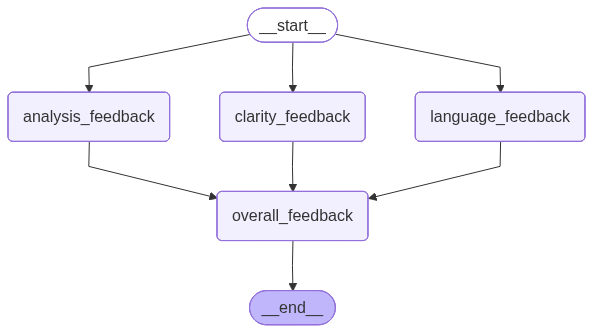

In [89]:
workflow

In [90]:
intial_state = {
    'essay': essay
}

workflow.invoke(intial_state)

{'essay': "India in the Age of AI\nAs the world enters a transformative era defined by artificial intelligence (AI), India stands at a critical juncture — one where it can either emerge as a global leader in AI innovation or risk falling behind in the technology race. The age of AI brings with it immense promise as well as unprecedented challenges, and how India navigates this landscape will shape its socio-economic and geopolitical future.\n\nIndia's strengths in the AI domain are rooted in its vast pool of skilled engineers, a thriving IT industry, and a growing startup ecosystem. With over 5 million STEM graduates annually and a burgeoning base of AI researchers, India possesses the intellectual capital required to build cutting-edge AI systems. Institutions like IITs, IIITs, and IISc have begun fostering AI research, while private players such as TCS, Infosys, and Wipro are integrating AI into their global services. In 2020, the government launched the National AI Strategy (AI for 